## River Turbidity Estimation using Sentinel-2

## Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#4)
* [Methodology](#5)
* [Prepare data for analysis](#6)
    * [Create geometry of AOI ](#7)
    * [Filter out sentinel-2 tiles](#8)
    * [Extract bands](#9)
* [Generate water body mask](#10)
    * [Create normalized difference water index raster](#11)
    * [Create binary raster](#12)
    * [Create water body mask](#13)
* [Normalized difference turbidity index](#14)
    * [Turbidity raster for water bodies ](#15)
* [Visualize results](#16)
    * [Get the results](#17)
    * [Interpretation of results](#20)
* [Conclusion](#21)
* [literature resources](#22)

## Introduction <a class="anchor" id="1"></a>

Turbidity represents the level of suspended sediments in water also indicating water clarity or how clear is the water. It is mainly caused by the presence of silt, algae in a water body, or industrial waste disposed in the rivers by mining activity, industrial operations, logging, etc.

Traditionally, turbidity is analyzed by evaluating water samples taken during field measurements. However, field studies are expensive, time and labor intensive, besides, during lockdown field surveys cannot be undertaken. Thus, a good alternative to field survey measurements is satellite remote sensing data, which can capture both spatial and temporal variations in river turbidity levels. Accordingly, Sentinel-2 multispectral data is used in the current study to evaluate the changes in river turbidity during COVID-19 lockdown, near the holy city of Allahabad, India.

Allahabad, situated in the northern part of India, is at the confluence of two major rivers: Ganga and its tributary river Yamuna. The point of confluence is a sacred place for Hindus where thousands of devotees gather everyday by the banks of the river to offer prayers. Millions of people depend on the waters from these rivers yet both rivers are heavily polluted by industrial waste, by sewage and even by the remains of the many bodies cremated on their banks. On March 25, 2020, India announced a lockdown for controlling the spread of COVID-19 leading to complete shutdown of industries and restricted human movement. The lockdown resulted in reduction of turbidity thereby improving water quality in rivers throughout the country. This notebook will elaborate the steps to measure this change in turbidity using ArcGIS API for Python.

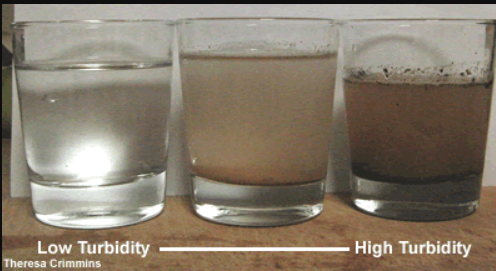

## Necessary Imports <a class="anchor" id="2"></a>

In [1]:
import pandas as pd
from ipywidgets import HBox, VBox, Label, Layout


import arcgis
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.raster.analytics import convert_feature_to_raster, convert_raster_to_feature
from arcgis.raster.functions import extract_band, greater_than, clip, remap, colormap, stretch
from arcgis.features.analysis import dissolve_boundaries

## Connect to your GIS <a class="anchor" id="3"></a>

In [2]:
from arcgis import GIS
agol_gis = GIS('Home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Get the data for analysis <a class="anchor" id="4"></a>

[Sentinel-2 Views](https://www.arcgis.com/home/item.html?id=fd61b9e0c69c4e14bebd50a9a968348c) is used in the analysis, this multitemporal layer consists 13 bands with 10, 20, and 60m spatial resolution. The imagery layer is rendered on-the-fly and available for visualization and analytics.  This imagery layer pulls directly from the Sentinel-2 on AWS collection and is updated daily with new imagery.

In [3]:
s2 = agol_gis.content.get('fd61b9e0c69c4e14bebd50a9a968348c')
sentinel = s2.layers[0]
s2

<Item title:"Sentinel-2 Views" type:Imagery Layer owner:esri>

A feature layer was published which represents the extent of study area. This feature will be used for extracting Sentinel-2 tiles of study area.

In [4]:
aoi1 = agol_gis.content.search('title:allahabad_aoi owner:api_data_owner', 'Feature Layer Collection')[0]
aoi1

<Item title:"allahabad_aoi" type:Feature Layer Collection owner:api_data_owner>

## Methodology <a class="anchor" id="5"></a>

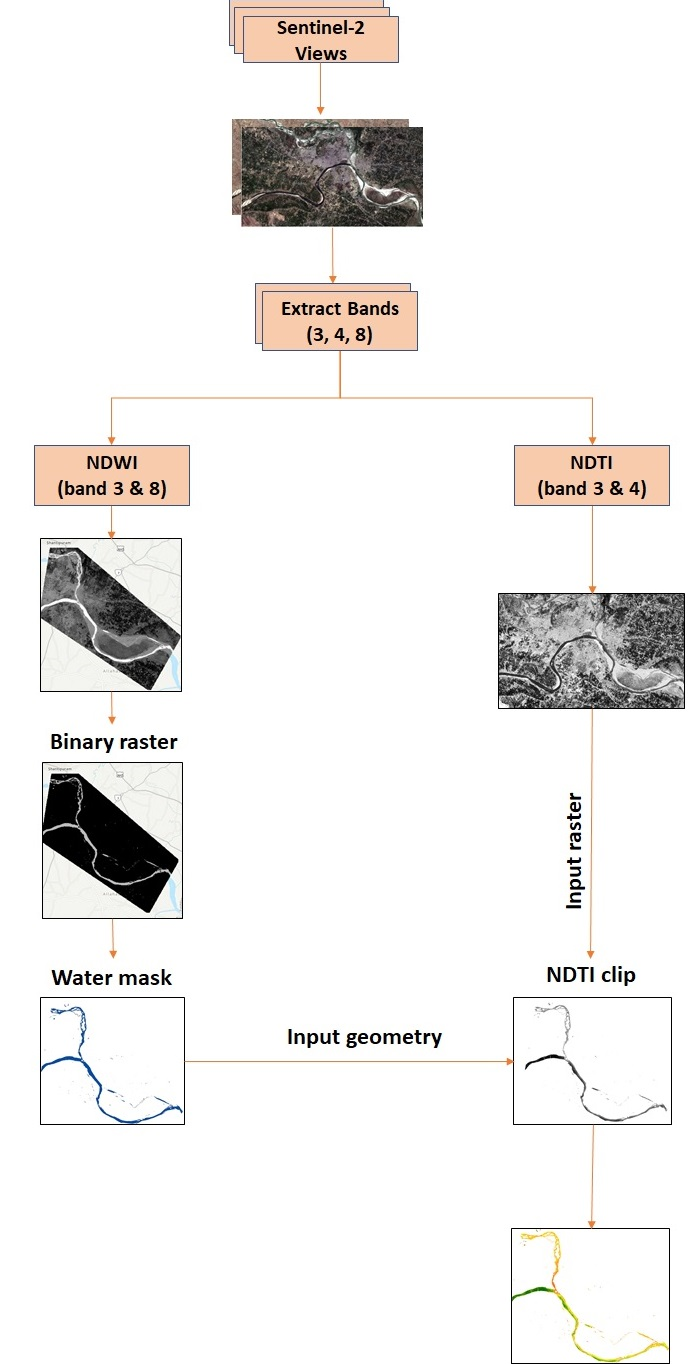

The above diagram encapsulates the overall methodology that has been followed in the estimation of the river turbidity.

## Prepare data for analysis <a class="anchor" id="6"></a>

`Sentinel-2 Views` imagery layer consists data for the whole world and span different time periods. Thus, the first step is to filter out the data for the rivers in Allahabad region prior to and during the lockdown period.

### Create geometry of area of interest (AOI) <a class="anchor" id="7"></a>

The geometry of AOI is created for filtering out the Sentinel-2 tiles for the study area.

In [5]:
aoi_layer = aoi1.layers[0]
aoi_feature = aoi_layer.query(where='fid=1')
aoi_geom = aoi_feature.features[0].geometry
aoi_geom['spatialReference'] = {'wkid':3857}

### Filter out sentinel-2 tiles  <a class="anchor" id="8"></a>

In [6]:
m = agol_gis.map('Allahabad, India', 11)
m

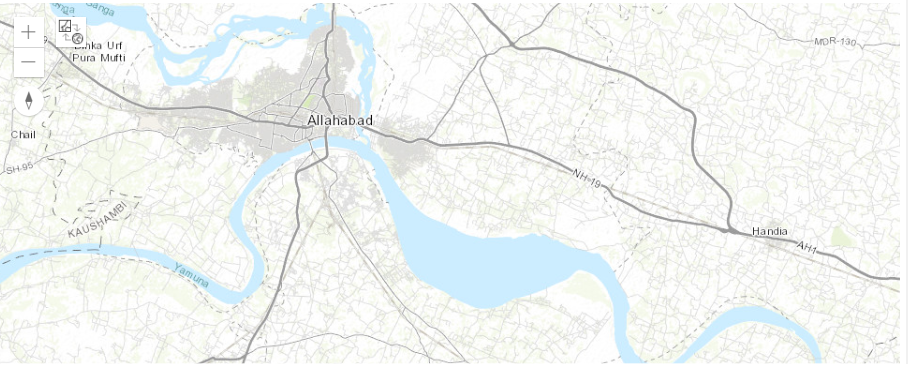

In [7]:
m.zoom_to_layer(aoi1)

#### Before lockdown

Sentinel-2 tiles were filtered out for before lockdown scenario using `query` function on the basis of `AcquistionDate` column. `Category` represents source of data, for the current analysis `Category=1` was used which means Sentinel-2 Level-1 data. Sentinel-2 tiles were filtered out for the before lockdown scenario from March 9, 2020 to March 11, 2020.

In [8]:
from datetime import datetime
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 3, 9), datetime(2020, 3, 11)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

objectid     acquisitiondate                groupname  cloudcover  \
0  10003774 2020-03-09 05:21:34  20200309T052134_44RPP_0           0   
1  10003775 2020-03-09 05:21:38  20200309T052137_44RNP_0           0   
2  10003776 2020-03-09 05:21:49  20200309T052148_44RPN_0           0   
3  10003777 2020-03-09 05:21:52  20200309T052152_44RNN_0           0   

   dayofyear   shape_Length    shape_Area  \
0         69  411289.670549  1.001614e+10   
1         69  486307.001820  1.478067e+10   
2         69  357605.263126  6.801910e+09   
3         69  482722.878472  1.456361e+10   

                                               SHAPE     AcquisitionDate  
0  {"rings": [[[9225034.6736, 3024534.521499999],... 2020-03-09 05:21:34  
1  {"rings": [[[9138906.555100001, 3025524.7907],... 2020-03-09 05:21:38  
2  {"rings": [[[9198149.502, 2913289.101599999], ... 2020-03-09 05:21:49  
3  {"rings": [[[9137984.507800002, 2913901.974500... 2020-03-09 05:21:52

Sentinel-2 tile of `OBJECTID=10003775` was selected which represents before lockdown turbidity conditions. 

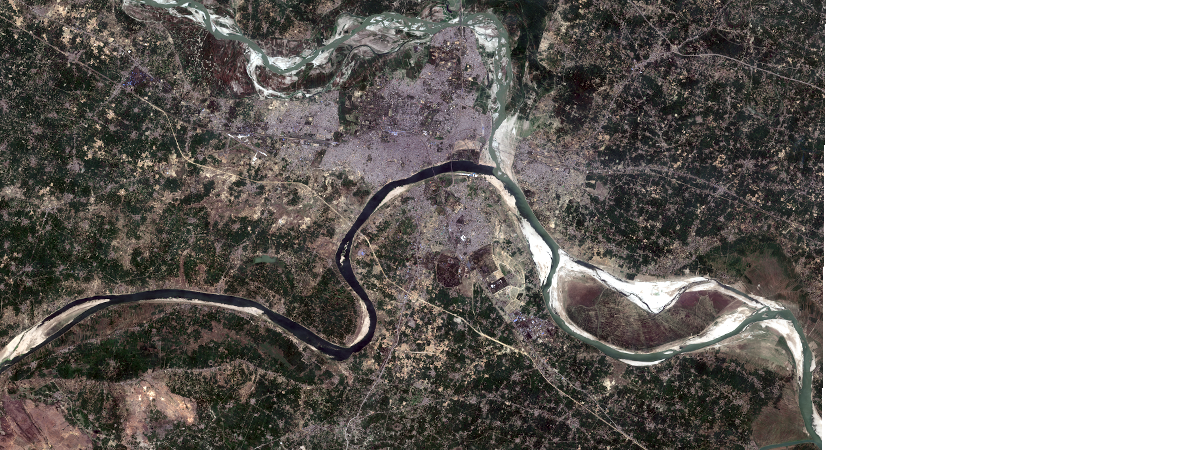

In [9]:
tile1 = sentinel.filter_by('OBJECTID=10003775')
tile1.extent = m.extent
tile1.save('s2_allbd_20200309', gis=ent_gis)
tile1

#### During lockdown

Sentinel-2 tiles were filtered out for during lockdown scenario using `query` function on the basis of `AcquistionDate` column. Sentinel-2 tiles were filtered out for the before lockdown scenario from April 9, 2020 to April 14, 2020.

In [10]:
from datetime import datetime
selected = sentinel.filter_by(where="(Category = 1)",
                             time=[datetime(2020, 4, 9), datetime(2020, 4, 14)],
                             geometry=arcgis.geometry.filters.intersects(aoi_geom))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                   order_by_fields="AcquisitionDate").sdf

df['AcquisitionDate'] = pd.to_datetime(df['acquisitiondate'], unit='ms')
df

objectid     acquisitiondate                groupname  cloudcover  \
0  10304744 2020-04-13 05:21:34  20200413T052134_44RPP_0      0.0207   
1  10481214 2020-04-13 05:21:38  20200413T052137_44RNP_0      0.0004   
2  10415547 2020-04-13 05:21:49  20200413T052148_44RPN_0      0.0000   
3  10415548 2020-04-13 05:21:52  20200413T052152_44RNN_0      0.0000   

   dayofyear   shape_Length    shape_Area  \
0        104  411250.271731  1.001344e+10   
1        104  486307.001820  1.478067e+10   
2        104  357554.873540  6.799904e+09   
3        104  482722.878472  1.456361e+10   

                                               SHAPE     AcquisitionDate  
0  {"rings": [[[9225023.4659, 3024534.6838000007]... 2020-04-13 05:21:34  
1  {"rings": [[[9138906.555100001, 3025524.7907],... 2020-04-13 05:21:38  
2  {"rings": [[[9198094.4782, 2913289.7751], [916... 2020-04-13 05:21:49  
3  {"rings": [[[9137984.507800002, 2913901.974500... 2020-04-13 05:21:52

Sentinel-2 tile of OBJECTID=10481214 was selected which represents during lockdown turbidity conditions.

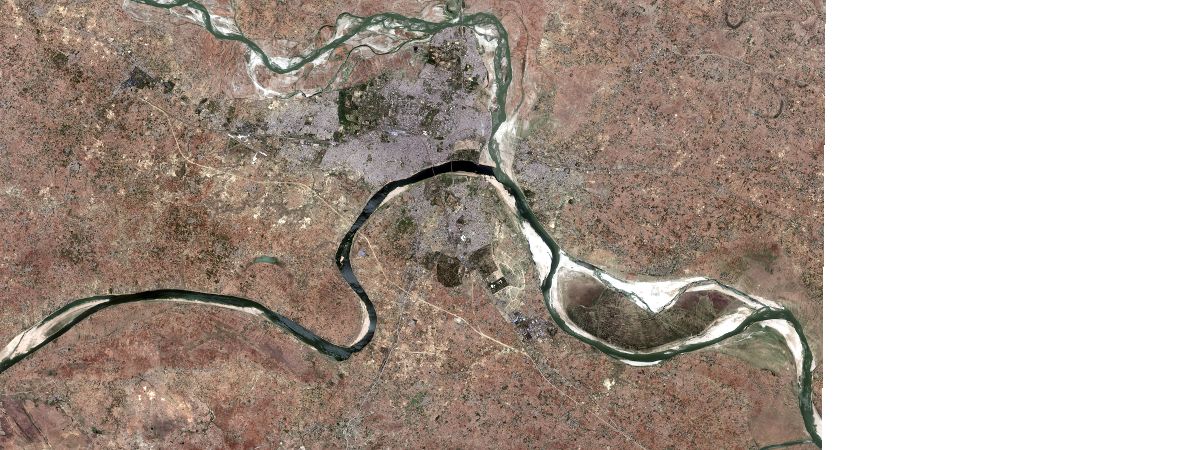

In [11]:
tile2 = sentinel.filter_by('OBJECTID=10481214')
tile2.extent = m.extent
tile2.save('s2_allbd_20200413', gis=ent_gis)
tile2

In [12]:
tiles = ent_gis.content.search('title:s2_allbd_')
tiles

In [13]:
timestamps=set([layer.title[-8:] for layer in tiles])
timestamps=[t.strftime('%Y%m%d') for t in sorted([datetime.strptime(t,'%Y%m%d') for t in timestamps])]

## Generate water body mask<a class="anchor" id="10"></a>

### Extract bands<a class="anchor" id="9"></a>

Green (band 3), Red (band 4) and NIR (band 8) bands were extracted from the Sentinel-2 tiles for NDWI and NDTI calculation.

In [14]:
def extract_green_band(tiles):
    print('extracting green band',end='\r')
    green_band = extract_band(tiles, [3])
    return green_band

In [15]:
def extract_red_band(tiles):
    print('extracting red band',end='\r')
    red_band = extract_band(tiles, [4])
    return red_band

In [16]:
def extract_nir_band(tiles):
    print('extracting nir band',end='\r')
    nir_band = extract_band(tiles, [8])
    return nir_band

### Create normalized difference water (NDWI) index raster<a class="anchor" id="11"></a>

Normalized difference water index (NDWI) is a satellite based index used for mapping and detecting the surface water bodies. Water absorbs electromagnetic radiation in visible to infrared spectrum, that is why Green and Near Infrared bands are used to detect the water bodies. In the current study, band 3 (green) and band 8 (NIR) of Sentinel-2 are used for generating NDWI raster. Here, `t` represents timestamps.

In [17]:
def create_ndwi_raster(green_band, nir_band, t, aoi_geom):
    print('creating ndwi raster',end='\r')
    ndwi = (green_band - nir_band)/(green_band + nir_band)
    c_ndwi = clip(ndwi, aoi_geom)
    ndwi_s = c_ndwi.save("ndwi_allbdt"+t, gis=ent_gis)
    ndwi_lyr = ndwi_s.layers[0]
    return ndwi_lyr

### Create binary raster<a class="anchor" id="12"></a>

Binary raster is created from NDWI raster using a threshold value. The binary raster consists of two classes of water and non-water pixels where pixels with value greater than 0.03 are considered as water. Accordingly, this threshold value of 0.03 is used for creating the binary raster using the [greater_than](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/greater-than.htm) function. Here, `t` represents timestamps. 

In [18]:
def create_binary_raster(ndwi_lyr, t):
    print('creating binary raster',end='\r')
    binary_raster = greater_than([ndwi_lyr, 0.03], 
                              extent_type='FirstOf', 
                              cellsize_type='FirstOf', 
                              astype='U16')
    binary_ras = binary_raster.save("binaryrast_"+t, gis=ent_gis)
    binaryras_lyr = binary_ras.layers[0]
    return binaryras_lyr

### Create water body mask<a class="anchor" id="13"></a>

#### Convert binary raster to feature layer

The binary rasters are converted to feature layer for extracting the boundaries of the water bodies. Here, `t` represents timestamps.

In [19]:
def create_binary_poly(binaryras_lyr, t):
    print('creating binary feature layer',end='\r')
    binary_poly = convert_raster_to_feature(binaryras_lyr, 
                                          field='Value', 
                                          output_type='Polygon', 
                                          simplify=True, 
                                          output_name='binary_poly'+t, 
                                          gis=ent_gis)
    return binary_poly

#### Extract water polygons

In the feature layer returned above, 'gridcode=0' represents non water class and 'gridcode=1' represents water class. Thus, the water polygons with 'gridcode=1 are selected using the `query` function from the dataframe of the feature layer and saved into a new feature layer created using `gis.content.import` function consisting of these water polygons. Here, `t` represents timestamps.

In [20]:
def extract_water_polygons(binary_poly, t):
    print('extracting water polygon',end='\r')
    dfm=binary_poly.layers[0].query('gridcode=1').sdf 
    water_poly=gis_ent.content.import_data(dfm, title='wpoly'+t)
    return water_poly

The features of `water_poly` were dissolved using [dissolve_boundaries](https://pro.arcgis.com/en/pro-app/tool-reference/feature-analysis/dissolve-boundaries.htm) function. The features were dissolved on the basis of `gridcode` column.

Finally the features in the layer `water_poly` are dissolved using [dissolve_boundaries](https://pro.arcgis.com/en/pro-app/tool-reference/feature-analysis/dissolve-boundaries.htm) function on the basis of gridcode column to obtain the water body mask in the following.

In [21]:
def dissolve_water_features(water_poly, t):
    print('dissolving water features',end='\r')
    diss_f = dissolve_boundaries(water_poly,
                                 dissolve_fields=['gridcode'], 
                                 output_name='dissolve_poly'+t, 
                                 gis=ent_gis,  
                                 multi_part_features=True)
    return diss_f

###  Normalized difference turbidity index<a class="anchor" id="14"></a>

The Normalize Difference Turbidity Index (NDTI) which is estimated using the spectral reflectance values of the water pixels is used to estimate the turbidity in water bodies. It uses the phenomenon that the electromagnetic reflectance is higher in green spectrum than the red spectrum for clear water. Hence, with increase in turbidity the reflectance of red spectrum also increases. Accordingly, in the current study, Sentinel-2 green (band 3) and red (band 4) bands are used to create the NDTI raster in the following. Here, t represents timestamps.

In [22]:
def create_ndti_ras(red_band, green_band, t):
    print('creating ndti raster',end='\r')
    ndti = (red_band - green_band)/(red_band + green_band)
    ndti_s = ndti.save("ndti_allbd"+t, gis=ent_gis)
    ndti_lyr = ndti_s.layers[0]
    return ndti_lyr

### Turbidity raster for water bodies<a class="anchor" id="15"></a>

Once the NDTI raster is prepared, its portion for the water body is extracted using the water body mask obtained earlier. To do so, fwe start by creating the geometry of `dissolve_f` as follows:

In [23]:
def create_water_geom(diss_f):
    print('creating geometry',end='\r')
    aoi2_layer = diss_f.layers[0]
    aoi2_feature = aoi2_layer.query(where='gridcode=1')
    aoi2_geom = aoi2_feature.features[0].geometry
    aoi2_geom['spatialReference'] = {'wkid':3857}
    return aoi2_geom

Second step is to [clip](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#clip) the NDTI rasters with the geometry of `dissolve_f` raster. Here, t represents timestamps.

In [24]:
def clip_water_ndti_ras(ndti_lyr, aoi2_geom, t):
    print('clipping ndti raster with water boundary',end='\r')
    clip_ndti = clip(ndti_lyr, aoi2_geom)
    clip_ndti_ras = clip_ndti.save("cl_ndti"+t, gis=ent_gis)
    return clip_ndti_ras

Third step is to apply [colormap](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html?highlight=colormap#arcgis.raster.functions.colormap) for visualizing the results. Here, t represents timestamps.

In [25]:
def stretch_ndti_ras(clip_ndti_ras, t):
    print('clipping stretch ndti raster',end='\r')
    stretch_rs = colormap(stretch(clip_ndti_ras.layers[0], 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")
    ndti_cmap = stretch_rs.save("ndti_cmapr"+t, gis=ent_gis)
    return stretch_ras

Finally, all of the above mentioned functions are used inside a loop and applied on the satellite imagery of the river from two different time periods: one before lockdown (March 9, 2020) and the second, during the lockdown period (April 13, 2020), to visualize and compare the difference in the turbidity levels.

In [26]:
for t in timestamps:
    
    print(f'Processing layers for :{t}\n')
    tiles = ent_gis.content.search(f's2_allbd_{t}')[0].layers[0]
    green_band=extract_green_band(tiles=tiles)
    red_band=extract_red_band(tiles=tiles) 
    nir_band=extract_nir_band(tiles=tiles) 
    ndwi_lyr=create_ndwi_raster(green_band=green_band, nir_band=nir_band, t=t, aoi_geom=aoi_geom)
    binaryras_lyr=create_binary_raster(ndwi_lyr=ndwi_lyr, t=t)
    binary_poly=create_binary_poly(binaryras_lyr=binaryras_lyr, t=t)
    water_poly=extract_water_polygons(binary_poly=binary_poly, t=t)
    diss_f=dissolve_water_features(water_poly=water_poly, t=t)
    ndti_lyr=create_ndti_ras(green_band=green_band, red_band=red_band, t=t)
    aoi2_geom=create_water_geom(diss_f=diss_f)
    clip_ndti_ras=clip_water_ndti_ras(ndti_lyr=ndti_lyr, aoi2_geom=aoi2_geom, t=t)
    stretch_ras=stretch_ndti_ras(clip_ndti_ras=clip_ndti_ras, t=t)
    print(f'Processing completed for :{t}\n')

Processing layers for :20200309

Processing completed for :20200309

Processing layers for :20200413

Processing completed for :20200413



## Visualize results<a class="anchor" id="16"></a>

### Result Visualization<a class="anchor" id="17"></a>

The NDTI rasters and their corresponding Sentinel-2 tiles are now accessed from the portal and used for visualization.

In [27]:
ras1 = ent_gis.content.search('ndti_cmap20200309', 'Imagery Layer')[0]
ras2 = ent_gis.content.search('ndti_cmap20200413', 'Imagery Layer')[0]
ras3 = ent_gis.content.search('s2_allbd_20200309', 'Imagery Layer')[0]
ras4 = ent_gis.content.search('s2_allbd_20200413', 'Imagery Layer')[0]

### Create map widgets<a class="anchor" id="17"></a>

4 map wigets are created representing the NDTI raster and corresponding Sentinel-2 for 9th March (before lockdown) and 13th April (during lockdown).

In [28]:
map1 = ent_gis.map("Allahabad, India", 12)
map1.basemap = 'national-geographic'
map1.add_layer(ras1)
map2 = ent_gis.map("Allahabad, India", 12)
map2.basemap = 'national-geographic'
map2.add_layer(ras2)
map3 = ent_gis.map("Allahabad, India", 12)
map3.add_layer(ras3)
map4 = ent_gis.map("Allahabad, India", 12)
map4.add_layer(ras4)

### Synchronize web maps<a class="anchor" id="18"></a>

All the maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It helps in comparing the river turbidity before and during lockdown. Detailed description about advanced map widget options can be referred [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/)

In [29]:
map1.sync_navigation(map2)
map2.sync_navigation(map3)
map3.sync_navigation(map4)

### Set the map layout<a class="anchor" id="19"></a>

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [30]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1,hb2=HBox([Label('NDTI (March 9, 2020)'),Label('NDTI (April 13, 2020)')]),\
                HBox([Label('Sentinel-2 (March 9, 2020)'),Label('Sentinel-2 (April 13, 2020)')])
hb1.layout,hb2.layout=hbox_layout,hbox_layout

### Interpretation of results<a class="anchor" id="20"></a>

In [31]:
VBox([hb1,HBox([map1,map2]),hb2, HBox([map3,map4])])

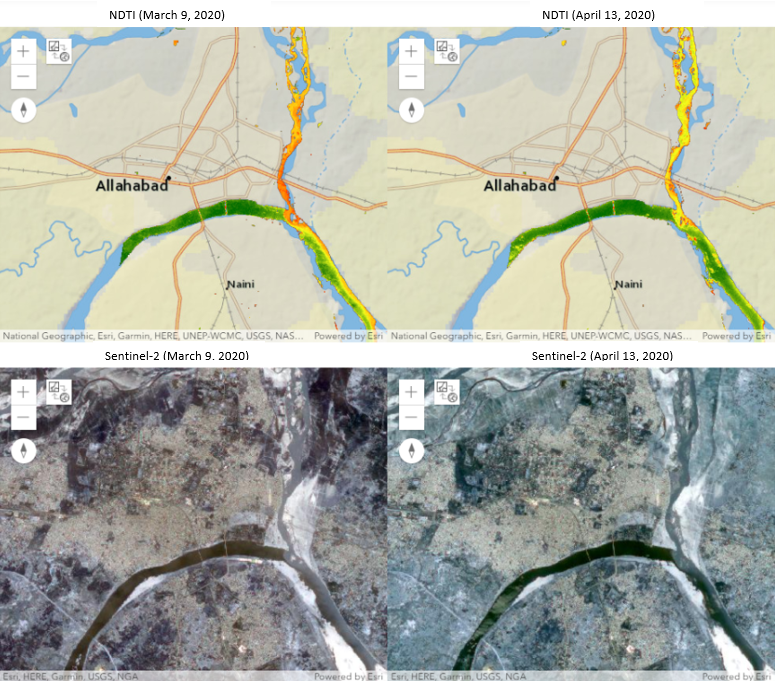

The maps above show the spatio-temporal variation in turbidity of the Ganga and Yamuna rivers due to Covid-19 lockdown. The satellite imageries used in the analysis are from before lockdown, dated March 9, 2020 (bottom-left), and during the lockdown, dated April 13, 2020 (botton-right).

It can be seen that turbidity declined in both the Ganga and Yamuna rivers during lockdown as indicated by the Red pixels representing high turbidity, turning to Orange, Yellow and finally Green, which is the lowest level of turbidity. Compared to Yamuna, the Ganga river had a significant impact on turbidity due to lockdown. The complete stretch of Ganga turned from red and yellow to mostly green pixels. The turbidity at the confluence point also declined followed by a decline in the stretch downstream.

## Conclusion<a class="anchor" id="21"></a>

Ganga and Yamuna rivers are among the world's most polluted due to dumping of waste from industrial and religious activities as indicated by their highly turbid water. During the lockdown period, pollution levels fell dramatically in both rivers due to complete shutdown of the above-mentioned functions. This change was investigated using Sentinel-2 satellite imageries of the river stretches, before and during the lockdown periods, with results suggesting substantial decrease in turbidity levels thereby validating the same. The same methodology can be implemented to study the changes in river turbidity for other regions with Sentinel-2 data using ArcGIS platform.

## Literature resources<a class="anchor" id="22"></a>

|Literature | Source | Link |
| -| - |-|
| Research Paper   | Changes in turbidity along Ganga River using Sentinel-2 satellite data during lockdown associated with COVID-19|https://www.tandfonline.com/doi/full/10.1080/19475705.2020.1782482|
| Research Paper   |Water Turbidity Assessment in Part of Gomti River Using High Resolution Google Earthâ€™s Quickbird satellite data|https://geospatialworldforum.org/2011/proceeding/pdf/Shivangifullpaper.pdf|